In [2]:
"""zero shot segmentation using segnet(image->word)"""
# imports without torch
import numpy as np
import argparse
import os
import os.path
import visdom
from PIL import Image
from tqdm import tqdm
import json

##########
# imports torch
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
##########

# imports models
import model.segnet as segnet
import model.encoder as encoder  # label->word
import model.decoder as decoder  # word->label
import zs_dataset_list as datasets

# imports utility
import make_log as flog

%load_ext line_profiler

In [3]:
def mod(x):
    if x == "true":
        return True
    if x =="false":
        return False
    return x


In [4]:
f_config = open(os.path.join("./config/MSE_batch12.json"), "r")
args = json.load(f_config)
args ={k:mod(v) for k,v in args.items()}
print(args)

# device settings
USE_CUDA = True

# input,label data settings
input_nbr = args["input_nbr"]  # 入力次元数
target_nbr = args["target_nbr"]  # 出力次元数

# set the seed
torch.manual_seed(args["seed"])
torch.cuda.manual_seed(args["seed"])

model = segnet.SegNet(input_nbr, target_nbr)
if USE_CUDA:  # convert to cuda if needed
    model.cuda()
else:
    model.float()
model=model.eval()

{'model': True, 'encoder': False, 'decoder': False, 'input_nbr': 3, 'target_nbr': 100, 'semantic_nbr': 0, 'batch_size': 12, 'epochs': 10, 'lr': 0.01, 'momentum': 0.5, 'seed': 1, 'lamda': 0, 'input_root': './data/train/input', 'target_root': './data/train/zs_target2', 'map_root': './data/train/target', 'filenames': './data/train/names.txt', 'semantic_filename': './v_class/class1.txt', 'project_dir': './model/MSE_batch12', 'model_load_pth': 'segnet.pth', 'head_load_pth': 'segnet.pth', 'save_pth': 'segnet.pth', 'output_dir': './data/MSE_batch12', 'n_components': 100, 'PCA': False, 'cos_similarity': False, 'jaccard_similarity': False}


In [5]:
# Create visdom
vis = visdom.Visdom()
# Create log model
f_log = flog.make_log(args["project_dir"])
optimizer = optim.SGD(model.parameters(),
                          lr=args["lr"], momentum=args["momentum"])

In [6]:
# compose transforms
train_transform = transforms.Compose(
    [transforms.RandomResizedCrop(256, scale=(1.0, 1.0), ratio=(1.0, 1.0))]
)
test_transform = transforms.Compose(
    []
)

# load dataset
trainset = datasets.ImageFolderDenseFileLists(
    input_root=args["input_root"], target_root=args["target_root"],
    map_root=args["map_root"], filenames=args["filenames"],
    semantic_filename=args["semantic_filename"], training=True,
    batch_size=args["batch_size"], config=args, transform=train_transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args["batch_size"], shuffle=True,
    num_workers=args["batch_size"])
testset = datasets.ImageFolderDenseFileLists(
    input_root='./data/test/input', target_root=None,
    map_root=None, filenames='./data/test/names.txt',
    semantic_filename=args["semantic_filename"], training=False,
    batch_size=1, config=args, transform=test_transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=1)

model.initialized_with_pretrained_weights()

  0%|          | 2/118286 [00:00<1:49:13, 18.05it/s]

removing grayscales ...


 48%|████▊     | 2396/5000 [00:00<00:00, 11977.44it/s]

removing grayscales ...


100%|██████████| 5000/5000 [00:00<00:00, 11964.04it/s]


initialize from vgg16


In [7]:
def model_train(epoch, trainloader):
    # set model to train mode
    model.train()

    # update learning rate
    lr = args["lr"] * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # define a loss
    # 今回の場合背景クラスを考慮しないので重み付けはしない
    if USE_CUDA:
        loss = nn.MSELoss(size_average=True).cuda()
        l1_loss = nn.L1Loss(size_average=False).cuda()
    else:
        loss = nn.MSELoss(size_average=True)
        l1_loss = nn.L1Loss(size_average=False)

    total_loss = 0

    # define epoch_size
    epoch_size = len(trainloader)

    # define batch_loss
    batch_loss = 0

    # define lamda
    lamda = args["lamda"]

    # define annotations
    v_array = trainloader.dataset.v_array
    v_array = torch.from_numpy(v_array)

    # iteration over the batches
    sync()
    for batch_id, data in tqdm(enumerate(trainloader)):
        sync()
        # make batch tensor and target tensor
        input = Variable(data['input'])
        target = data['target']
        mask = data['mask']
        sync()
        if USE_CUDA:
            input = input.cuda()
            target = target.cuda()
            mask = mask.cuda()
            v_array = v_array.cuda()
        sync()
        # initialize gradients
        optimizer.zero_grad()
        sync()
        # predictions
        output = model(input)
        sync()
        # mask tensor
        output = output * mask
        target = target * mask
        sync()
        # calculate loss
        l_ = 0
        l_ = loss(output, target)
        l_ = l_ * output.size(1)
        sync()
        if lamda != 0:
            reg_loss = 0
            for param in model.parameters():
                if USE_CUDA:
                    param_target = Variable(torch.zeros(param.size())).cuda()
                else:
                    param_target = Variable(torch.zeros(param.size()))
                reg_loss += l1_loss(param, param_target)

            reg_loss = lamda * reg_loss
            l_ += l_ + reg_loss
        sync()
        total_loss += l_.item()
        sync()
        # backward loss
        l_.backward()
        sync()
        # optimizer step
        optimizer.step()
        sync()
        # train conditions
        """
        if lamda != 0:
            print("epoch=%d, id=%d, reg_loss=%f, loss=%f" %
                 (epoch, batch_id, reg_loss.item(), l_.item()))
        else:
            print("epoch=%d, id=%d, loss=%f" %
                 (epoch, batch_id, l_.item()))
        """

        # visualize train condition
        if batch_id % 10 == 0 and batch_id != 0:
            batch_loss = batch_loss + l_.item()
            batch_loss = batch_loss / 10
            # display visdom board
            phase = epoch + batch_id / epoch_size
            #visualize(phase, batch_loss, win)
            batch_loss = 0
        else:
            batch_loss = batch_loss + l_.item()
        if batch_id % 10000 == 0 and batch_id != 0:
            target_map = data["map"]
            model.eval()
            output = model(input)
            model_evaluate(output, target_map, v_array,
                           epoch, epoch_size, batch_id)
            model.train()
        if batch_id ==1000:
            break
        sync()
    return total_loss

def model_test(testloader):
    # set model to eval mode
    model.eval()

    # define v_array
    v_array = testloader.dataset.v_array
    v_array = torch.from_numpy(v_array)

    # make output_dir
    if not os.path.isdir(args["output_dir"]):
        os.makedirs(args["output_dir"])

    # iteration over the batches
    for batch_id, data in enumerate(testloader):
        # make batch tensor and target tensor
        input = Variable(data['input'])

        if USE_CUDA:
            input = input.cuda()
            v_array = v_array.cuda()

        # predictions
        output = model(input)

        # output segmentation_img
        filename = os.path.basename(
            testloader.dataset.get_filename(batch_id)[0])
        print(filename)
        single_output = output[0, :, :, :]
        if args["cos_similarity"] is True or args["jaccard_similarity"] is True:
            result = single_output.max(0)[1].cpu().numpy()
            result = np.uint8(result)
        else:
            single_output = single_output.transpose(0, 1).transpose(1, 2)
            result = min_euclidean(single_output, v_array)
            result = np.uint8(result.cpu().numpy())

        Image.fromarray(result).save(
            os.path.join(args["output_dir"], filename))


def model_evaluate(output, target_map, v_array, epoch, epoch_size, batch_id):
    data_num = 0
    correct_num = 0
    print("evaluating ...")
    for id in tqdm(range(output.shape[0])):
        single_output = output[id, :, :, :]
        target = target_map[id, :, :].cpu().numpy()
        if args["cos_similarity"] is True or args["jaccard_similarity"] is True:
            result = single_output.max(0)[1].cpu().numpy()
            result = np.uint8(result)
        else:
            single_output = single_output.transpose(0, 1).transpose(1, 2)
            result = min_euclidean(single_output, v_array)
            result = np.uint8(result.cpu().numpy())

        for i in range(output.size(2)):
            for j in range(output.size(3)):
                if target[i, j] < 200:
                    data_num = data_num + 1
                    if result[i, j] == target[i, j]:
                        correct_num = correct_num + 1
    phase = epoch + batch_id / epoch_size
    visualize(phase, (correct_num / data_num), win_acc)


def visualize(phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )


def min_euclidean(out, sem):
    """pytorch calculate euclidean"""
    nbr = out.size(1)
    ab = torch.mm(out.view(-1, nbr), sem.t())
    ab = ab.view(out.size(0), out.size(1), sem.size(0))
    aa = (sem**2).sum(1)
    bb = (out**2).sum(-1)
    res = aa[None, None, :] + bb[:, :, None] - 2 * ab
    return res.min(-1)[1]


def min_euclidean2(out, sem):
    """numpy calculate euclidean"""
    ab = np.dot(out, sem.transpose())
    aa = (sem**2).sum(1)
    bb = (out**2).sum(-1)
    res = aa[None, None, :] + bb[:, :, None] - 2 * ab
    return res.argmin(-1)

# Profiling

In [88]:
def timer1():
    for batch_id, data in enumerate(trainloader):
        break
        
%time timer1()

SYNC = True

def sync():
    if SYNC:
        torch.cuda.synchronize()

CPU times: user 40 ms, sys: 1.29 s, total: 1.33 s
Wall time: 6.39 s


In [89]:
%lprun -f model_train model_train(0, trainloader)

1000it [08:55,  1.87it/s]

Timer unit: 1e-06 s

Total time: 537.404 s
File: <ipython-input-7-eebfb64d5152>
Function: model_train at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def model_train(epoch, trainloader):
     2                                               # set model to train mode
     3         1        971.0    971.0      0.0      model.train()
     4                                           
     5                                               # update learning rate
     6         1          9.0      9.0      0.0      lr = args["lr"] * (0.1 ** (epoch // 30))
     7         2         14.0      7.0      0.0      for param_group in optimizer.param_groups:
     8         1          5.0      5.0      0.0          param_group['lr'] = lr
     9                                           
    10                                               # define a loss
    11                                               # 今回の場合背景クラスを考慮しないので重み付け

# Investigate model

In [11]:
epoch = 0
import torch.nn.functional as F

In [12]:
model.train()

# update learning rate
lr = args["lr"] * (0.1 ** (epoch // 30))
for param_group in optimizer.param_groups:
    param_group['lr'] = lr

loss = nn.MSELoss(size_average=True)

In [ ]:
output
target_map
v_array
epoch
epoch_size
batch_id

In [ ]:
def min_euclidean(out, sem):
    """pytorch calculate euclidean"""
    nbr = out.size(1)
    ab = torch.mm(out.view(-1, nbr), sem.t())
    ab = ab.view(out.size(0), out.size(1), sem.size(0))
    aa = (sem**2).sum(1)
    bb = (out**2).sum(-1)
    res = aa[None, None, :] + bb[:, :, None] - 2 * ab
    return res.min(-1)[1]


In [ ]:
data_num = 0
correct_num = 0
print("evaluating ...")

single_output = output[id, :, :, :]
target = target_map[id, :, :].cpu().numpy()
single_output = single_output.transpose(0, 1).transpose(1, 2)

result = min_euclidean(single_output, v_array)
result = np.uint8(result.cpu().numpy())

In [ ]:
    for i in range(output.size(2)):
        for j in range(output.size(3)):
            if target[i, j] < 200:
                data_num = data_num + 1
                if result[i, j] == target[i, j]:
                    correct_num = correct_num + 1

phase = epoch + batch_id / epoch_size


In [13]:
total_loss = 0
epoch_size = len(trainloader)
batch_loss = 0
lamda = args["lamda"]
v_array = trainloader.dataset.v_array
v_array = torch.from_numpy(v_array)
v_array = F.normalize(v_array)

In [22]:
#F.normalize(v_array,)
#v_array#.size()

In [80]:
for batch_id, data in tqdm(enumerate(trainloader)):
    break

0it [00:00, ?it/s]


In [87]:
#Y=np.unique(data["map"][0].cpu().numpy(), return_counts=True)[1]
#Y/Y.sum()

In [24]:
data.keys()

dict_keys(['input', 'target', 'mask', 'map'])

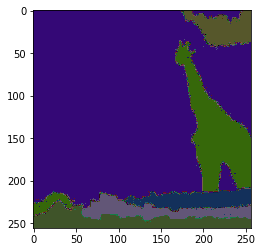

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
cmap = np.random.randint(0,126, (400,3))
x = data["map"][1].cpu().numpy()
plt.imshow(cmap[x])

In [53]:
from torchvision.transforms.transforms import Resize
#Resize()
#PIL.Image.NEAREST
#x=np.unique(x, return_counts=True)
#data["mask"].cpu().numpy()#plt.imshow(data["mask"][0,0].cpu().numpy())

In [61]:
x = data["mask"][:,0:1]
x.size()mask = mask.transpose(2, 0, 1)

torch.Size([12, 1, 256, 256])

In [63]:
output=data["target"]
output.size()

(x*output).size()

torch.Size([12, 100, 256, 256])

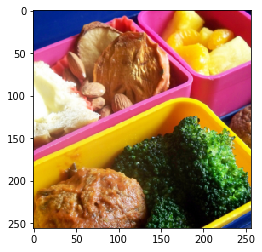

In [34]:
x = data["input"][0].cpu().numpy()
x= x.transpose(1,2,0)
plt.imshow(x)
#data["input"][0]#.size()

In [76]:
#torch.__version__
#x=torch.ones((3,3), requires_grad=True)
#x.sum().backward()
#x.data, x.grad
v_array = v_array.cuda()

In [78]:
# sync()
# make batch tensor and target tensor
input = data['input']#Variable(data['input'])
target = data['target']
mask = data['mask']
sync()

if USE_CUDA:
    input  = input.cuda()
    target = target.cuda()
    mask   = mask.cuda()
    
sync()
# initialize gradients
optimizer.zero_grad()
sync()
# predictions
output = model(input)
sync()
# mask tensor
output = output * mask
target = target * mask
sync()
# calculate loss
l_ = 0
l_ = loss(output, target)
l_ = l_ * output.size(1)
sync()
if lamda != 0:
    reg_loss = 0
    for param in model.parameters():
        if USE_CUDA:
            param_target = Variable(torch.zeros(param.size())).cuda()
        else:
            param_target = Variable(torch.zeros(param.size()))
        reg_loss += l1_loss(param, param_target)

    reg_loss = lamda * reg_loss
    l_ += l_ + reg_loss
sync()
total_loss += l_.item()
sync()
# backward loss
l_.backward()
sync()
# optimizer step
optimizer.step()
sync()

In [ ]:
data.keys()

In [ ]:
epoch=0 
loss = model_train(epoch, trainloader)
model_test(testloader)